# User PIN Analysis and Guessing PIN smartly using Markov Chain

For password cracking Bruteforce has been used exhaustively among cybersecurity experts. But is the bruteforce is best best approch? Can we guess the users password smartly? Does there exists any pattern in user choosing PINs?

In this notebook we will try to answer all these questions.

### We will discuss
 - What's the distribution of passwords?
 - Patterns in the leading digits the users choose.
 - Comparing the outcomes with the Benford's Law.
 - Transition Probability Matrix for Markov Chain.
 - Guess password using the Markov Chain.

In [142]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rockyou-6-digit/DD-6-digit-291000.txt


# Let's Start with Loading our Dataset

## Rockyou

Rockyou 6-digit contains 291 thousand unique PINs provided by users anonymusly

In [143]:
string_pool = None
with open('/kaggle/input/rockyou-6-digit/DD-6-digit-291000.txt') as f:
    string_pool = f.readlines()
string_pool = list(map(lambda x:x.replace('\n',''),string_pool))
string_pool[:10]

['123456',
 '654321',
 '111111',
 '000000',
 '123123',
 '666666',
 '121212',
 '112233',
 '789456',
 '159753']

In [144]:
print(f"Total PINs Loaded: {len(string_pool)}")

Total PINs Loaded: 291000


### Now Lets change our dataset to a Pandas Dataframe

In [145]:
dataframe = pd.DataFrame({'pins':string_pool})
dataframe.head()

,pins
0,123456
1,654321
2,111111
3,000000
4,123123


In [146]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291000 entries, 0 to 290999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   pins    291000 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB


In [147]:
dataframe.describe()

,pins
count,291000
unique,291000
top,123456
freq,1


As we can clearly see that the count(unique)==count(total) which means that dataset got no repeated elements and we don't have to remove repeated elements.

In [148]:
dataframe['len']=dataframe.pins.str.len()
dataframe[dataframe['len']!=6]

,pins,len


It is clear that all the passwords we contains exactly 6 digits

## Now let's start inspecting the distribution of the PINs

For that first we have to change all the strings to numbers

<Axes: xlabel='pins', ylabel='Count'>

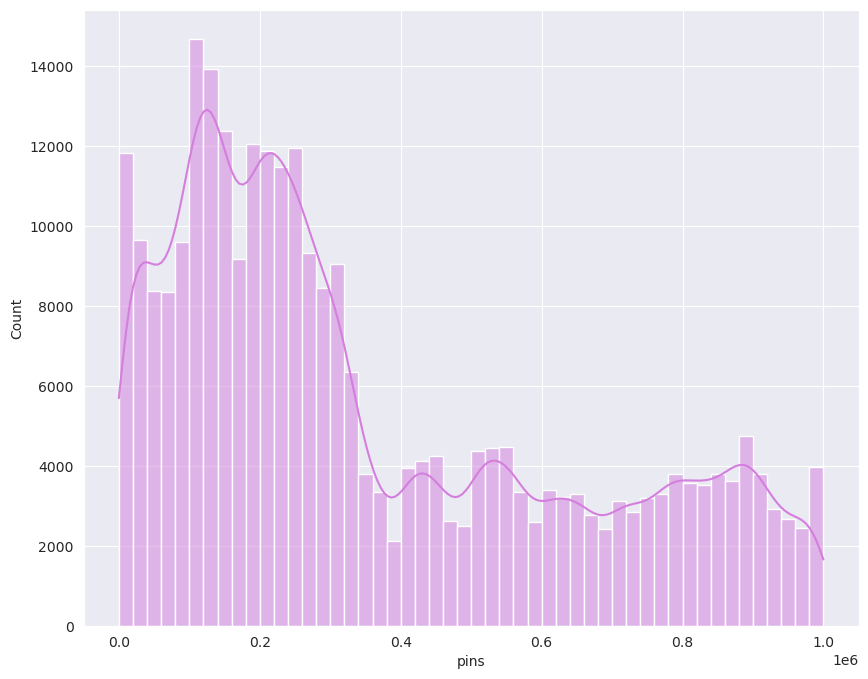

In [149]:
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize=(10,8))
sns.histplot(dataframe.pins.apply(int),bins=50,kde=True,color='#d47ede')

## The distribution is clearly concetrated to the left which means 0 to 500000

In [150]:
percentage = dataframe[dataframe.pins.apply(int)<=500000].pins.count()/len(dataframe)*100
print(f'{percentage}% of passwords are below "5000000"')

70.55601374570448% of passwords are below "5000000"


## Pattern in the Leading Digits

Now let's start extracting the leading digits and create a countplot for the occurences

In [151]:
dataframe['leading_digit'] = dataframe.pins.apply(lambda x:x[0])
dataframe[['pins','leading_digit']].head(8)

,pins,leading_digit
0,123456,1
1,654321,6
2,111111,1
3,000000,0
4,123123,1
5,666666,6
6,121212,1
7,112233,1


Now we have the leading digit, we can easily plot the graph

In [152]:
leading_digit_count = dataframe['leading_digit'].value_counts().to_dict()

In [153]:
leading_digit_count_list = sorted(list(leading_digit_count.items()))

<Axes: xlabel='leading_digit', ylabel='count'>

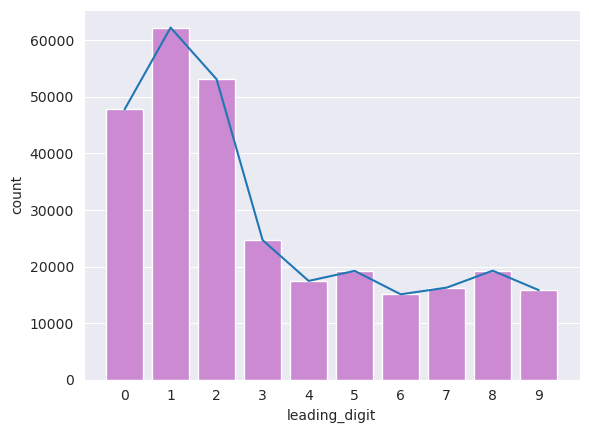

In [154]:
sns.countplot(x=dataframe['leading_digit'],color='#d47ede',order=[str(x) for x in range(10)])
sns.lineplot(x=[item[0] for item in leading_digit_count_list],y= [item[1] for item in leading_digit_count_list])

### The Pattern in picking the first digit of PIN is really interesting, it put '0' aside the likely hood follows the logarithmic degradation.



## Benford's Law

It states that: "In sets that obey the law, the number 1 appears as the leading significant digit about 30% of the time, while 9 appears as the leading significant digit less than 5% of the time. If the digits were distributed uniformly, they would each occur about 11.1% of the time."

![img](https://wikimedia.org/api/rest_v1/media/math/render/svg/48649074b19e71dc8dc5e8dd82717f05bc541b67)

In [155]:
benford_dist = [np.log10(1+(1/d)) for d in range(1,10)]
benford_dist

[0.3010299956639812,
 0.17609125905568124,
 0.12493873660829992,
 0.09691001300805642,
 0.07918124604762482,
 0.06694678963061322,
 0.05799194697768673,
 0.05115252244738129,
 0.04575749056067514]

<Axes: >

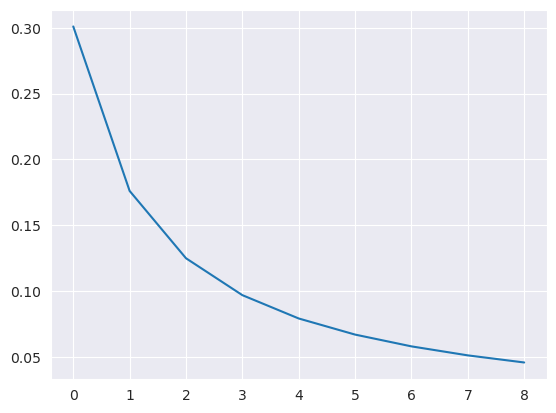

In [156]:
sns.lineplot(benford_dist)

Benford's law has been found to apply to a wide variety of data sets, including:

 - Populations of cities
 - Stock prices
 - Earthquake magnitudes
 - River flows
 - Measurements of physical constants
 - Data sets that have been intentionally manipulated often do not follow Benford's law. This makes Benford's law a useful tool for detecting fraud and other types of data manipulation.

## Let's compare our data with Benford's Distribution

In [157]:
digit_occurences = [item[1] for item in leading_digit_count_list]
dataset_distribution = [occurence/sum(digit_occurences) for occurence in digit_occurences]
dataset_distribution

[0.16425429553264606,
 0.2139828178694158,
 0.18255670103092783,
 0.08478006872852234,
 0.05998281786941581,
 0.06608591065292097,
 0.05184536082474227,
 0.055900343642611684,
 0.06621993127147767,
 0.05439175257731959]

<Axes: >

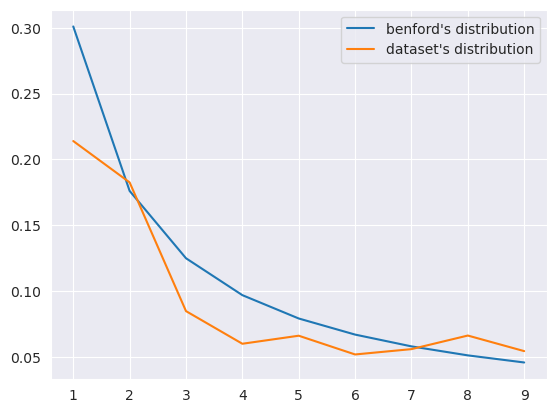

In [158]:
sns.lineplot(x=range(1,10),y=benford_dist,label="benford's distribution",legend=True)
sns.lineplot(x=range(1,10),y=dataset_distribution[1:],label="dataset's distribution",legend=True)

### The Plots look a lot similar.

## Creating Transition matrix

In this section we will be creating a transition matrix for the Markov Model.

#### Markov model

A [Markov model](https://en.wikipedia.org/wiki/Markov_model) is a stochastic model that describes a sequence of events. The model assumes that the probability of an event occurring depends only on the state of the system at the previous time step. This is known as the Markov property. 

#### Transition matrix

he state transition matrix of a Markov chain is a square matrix that describes the probabilities of transitioning from one state to another. The matrix is indexed by the states of the Markov chain, and the entries in the matrix are the probabilities of transitioning from one state to another.

In [159]:
transition_mat = [[0 for _ in range(10)] for a in range(10)]
transition_value_counts= [[0 for _ in range(10)] for _ in range(10)]
for pin in string_pool:
    for i in range(0,len(pin)-1):
        transition_mat[int(pin[i])][int(pin[i+1])]+=1


In [160]:
transition_mat

[[26946, 24482, 21934, 18945, 17588, 18543, 18060, 17673, 19617, 17739],
 [29101, 28865, 29002, 19870, 19306, 18912, 16447, 16151, 17894, 23732],
 [24146, 25249, 23123, 18902, 18521, 21617, 17583, 15593, 17359, 15280],
 [20782, 19986, 17080, 13136, 9318, 11328, 10869, 8434, 9008, 8572],
 [14465, 15727, 14404, 10334, 9755, 11444, 9590, 8878, 10129, 8426],
 [15913, 16458, 16629, 11543, 10908, 12194, 12924, 9051, 11141, 9627],
 [14663, 14685, 13518, 10242, 8659, 10398, 10887, 8896, 10260, 11682],
 [13304, 14012, 12066, 8154, 8557, 8789, 8260, 11218, 13173, 10149],
 [14804, 14582, 13619, 9714, 9947, 11669, 11276, 12005, 15038, 14253],
 [16747, 16037, 13615, 9821, 8597, 9869, 10203, 9403, 12437, 13559]]

In [161]:
sum_ = sum([sum(transition_mat[i]) for i in range(10)])
print(sum_)

1455000


In [162]:
transition_mat_np = np.array(transition_mat,dtype=float)
for i in range(10):
    transition_mat_np[i] = transition_mat_np[i]/transition_mat_np[i].sum().round(2)

In [163]:
for i in range(10):
    print(f"{i}: {transition_mat_np[i].sum()}")

0: 0.9999999999999999
1: 0.9999999999999999
2: 1.0
3: 1.0
4: 0.9999999999999999
5: 1.0
6: 1.0
7: 1.0
8: 1.0
9: 1.0


<Axes: >

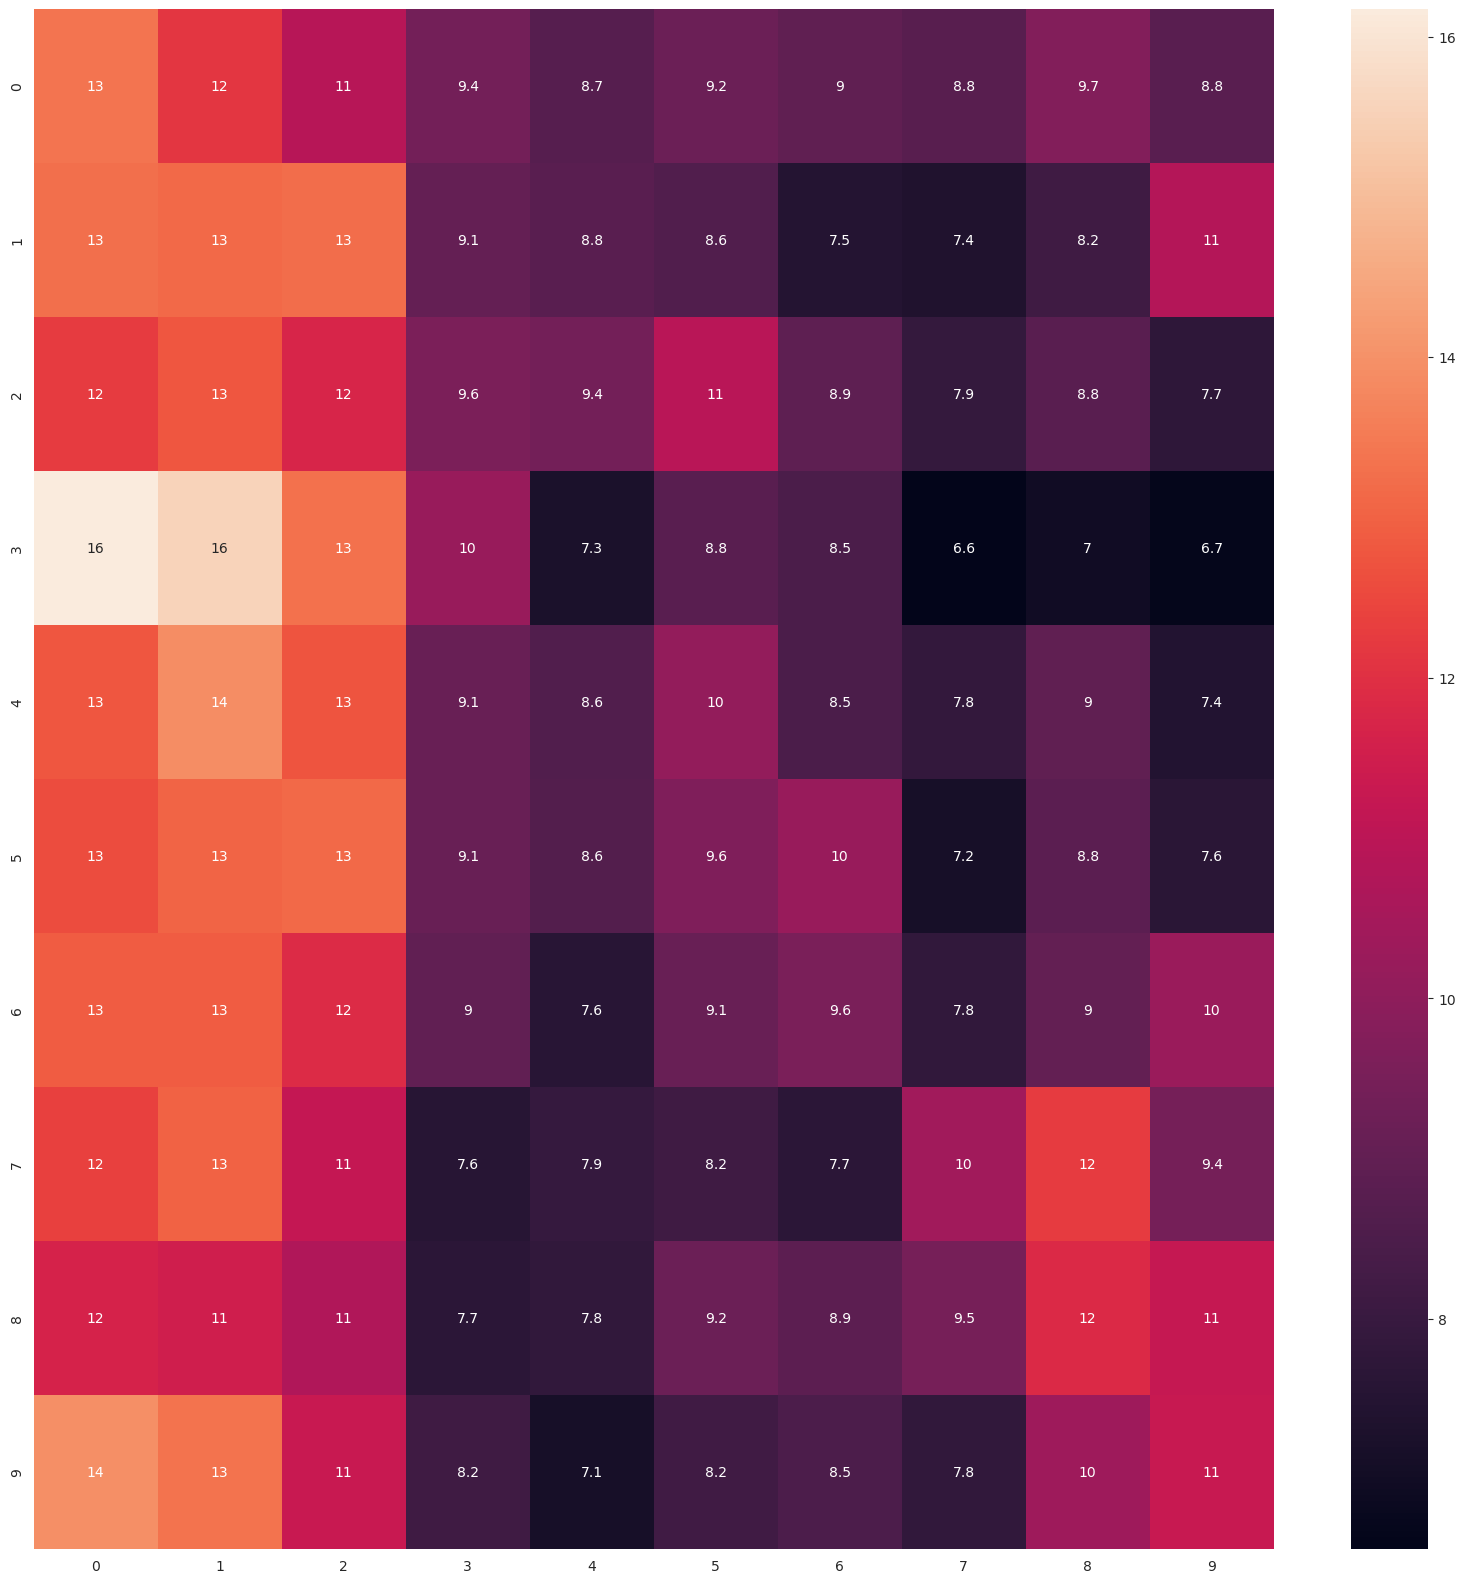

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
sns.heatmap((transition_mat_np)*100,annot=True)

## Time to Create our Markov Model

We will create a Markov model to generate more natural and human like passwords

In [165]:
digits_to_guess = 6
generate_password = ''
while digits_to_guess >0:
    digit = np.random.choice(range(10),p=dataset_distribution)
    digit = str(digit)
    generate_password+=digit
    digits_to_guess-=1
generate_password

'102103'

In [166]:
def generate_password(digits):
    digits_to_guess = digits
    generate_password = ''
    while digits_to_guess >0:
        digit = np.random.choice(range(10),p=dataset_distribution)
        digit = str(digit)
        generate_password+=digit
        digits_to_guess-=1
    return generate_password

## TIME TO GUESS PASSWORDS!

In [167]:
pass_ = '3232'
guessed_pass = ''
counter  =1
while guessed_pass!=pass_:
    digits_to_guess = len(pass_)
    guessed_pass = ''
    digit = np.random.choice(list(range(10)),p=dataset_distribution)
    while digits_to_guess>0:
        digit = np.random.choice(range(10),p=dataset_distribution)
        guessed_pass+=str(digit)
        digits_to_guess-=1
    #print(guessed_pass,"| Attempt",counter)
    counter+=1
print(counter)

10149


In [168]:
test_passwords = [generate_password(4) for _ in range(10)]

### Guessing Passwords with dataset distribution

In [ ]:
import datetime
now = datetime.datetime.now()
random_sampling_test_data = []
for pass_ in test_passwords:
    test_data = []
    for test in range(20):
        guessed_pass = ''
        counter  =1
        while guessed_pass!=pass_:
            digits_to_guess = len(pass_)
            guessed_pass = ''
            digit = np.random.choice(list(range(10)),p=dataset_distribution)
            guessed_pass+=str(digit)
            while digits_to_guess-1 >0:
                digit = np.random.choice(range(10),p=dataset_distribution)
                guessed_pass+=str(digit)
                digits_to_guess-=1
            #print(guessed_pass,"| Attempt",counter)
            counter+=1
        test_data.append(counter)
    print('Test complete!')
    random_sampling_test_data.append(test_data)


end = datetime.datetime.now()
print(end-now)

In [ ]:
print(f"On an average randomaztion with Markov transition probability is {np.array(random_sampling_test_data).mean()}/{10**4}")

### Guessing Password with transition matrix

In [ ]:
import datetime
now = datetime.datetime.now()
random_sampling_test_data = []
for pass_ in test_passwords:
    test_data = []
    for test in range(20):
        guessed_pass = ''
        counter  =1
        while guessed_pass!=pass_:
            digits_to_guess = len(pass_)
            guessed_pass = ''
            digit = np.random.choice(list(range(10)),p=dataset_distribution)
            guessed_pass+=str(digit)
            while digits_to_guess-1 >0:
                digit = np.random.choice(range(10),p=transition_mat_np[digit])
                guessed_pass+=str(digit)
                digits_to_guess-=1
            #print(guessed_pass,"| Attempt",counter)
            counter+=1
        test_data.append(counter)
    print('Test complete!')
    random_sampling_test_data.append(test_data)


end = datetime.datetime.now()
print(end-now)

In [ ]:
print(f"On an average randomaztion with Markov transition probability is {np.array(random_sampling_test_data).mean()}/{10**4}")

# THANK YOU FOR READING
## <i> By Mohammad Zaid Khan</i>

## Sources :
- Wikipedia for information
- Kaggle for dataset